In [17]:
%pip install numpy matplotlib graphviz torch

  Using cached torch-2.0.1-cp311-none-macosx_11_0_arm64.whl (55.8 MB)
  Using cached filelock-3.12.4-py3-none-any.whl (11 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.3-cp311-cp311-macosx_10_9_universal2.whl (17 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from graphviz import Digraph

def trace(root):
    # builds a set of all notes in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangle ('record') node for it 
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it 
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [34]:
class Value: 
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad 
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __neg__(self, other):
        return self * -1

    def __sub__(self, other): 
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

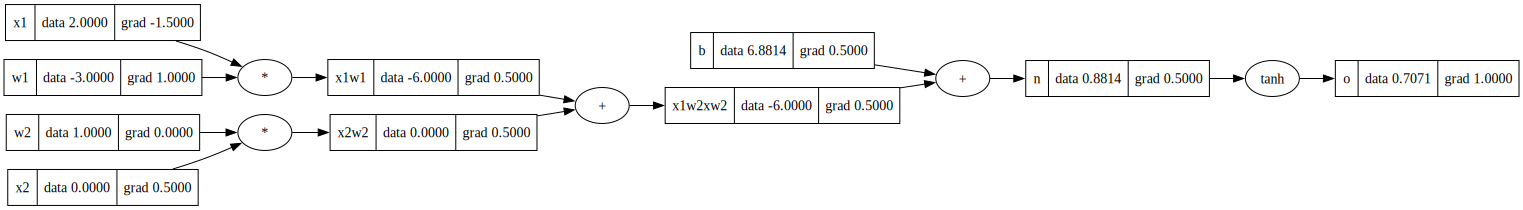

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w2xw2 = x1w1 + x2w2; x1w2xw2.label = 'x1w2xw2'
n = x1w2xw2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

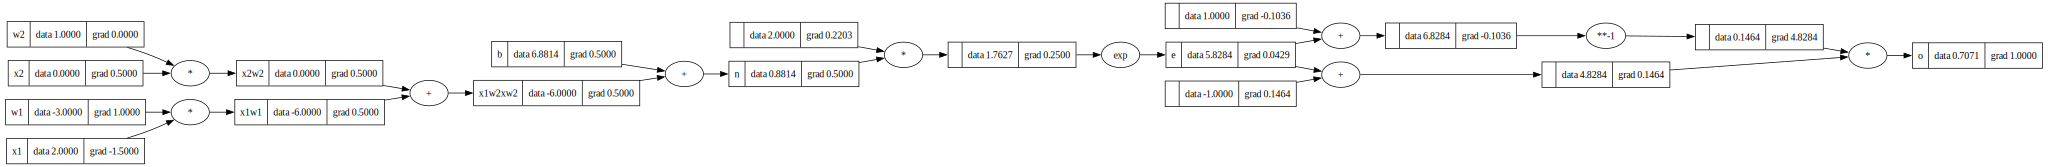

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w2xw2 = x1w1 + x2w2; x1w2xw2.label = 'x1w2xw2'
n = x1w2xw2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [28]:
import torch 

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


0.7071066904050358


In [30]:
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())
print(b.grad.item())


-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0
0.5000001283844369


In [61]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        return act.tanh()

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        szs = [nin] + nouts
        self.layers = [Layer(szs[i], szs[i+1]) for i in range(len(szs)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

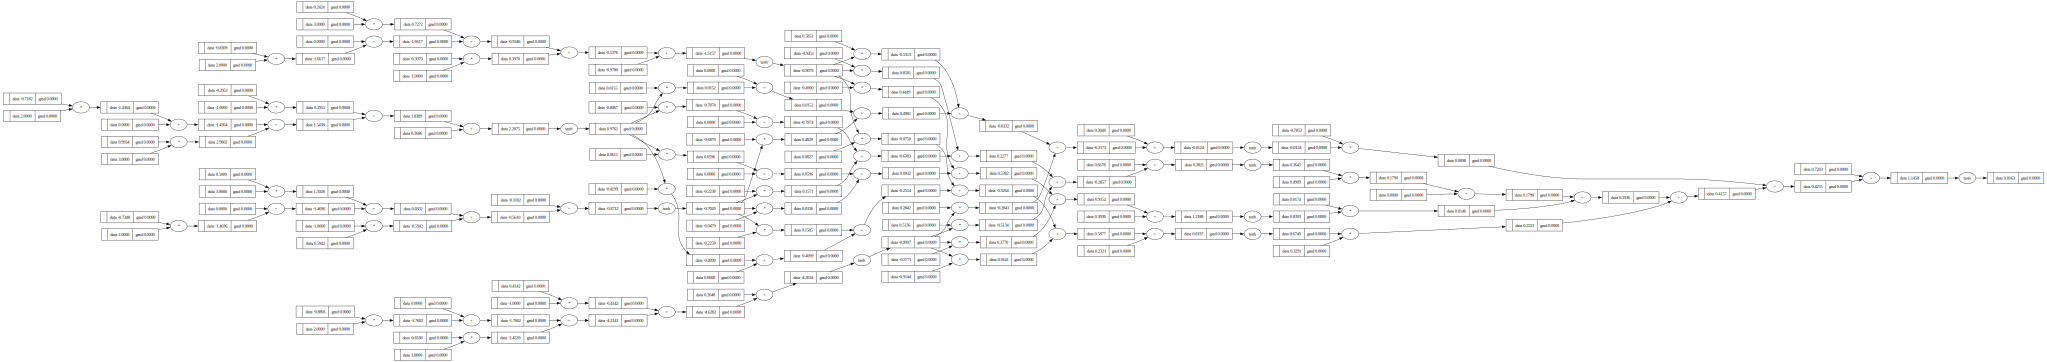

In [94]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [95]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # targets 

In [99]:
for k in range(20):
    # forward pass 
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update 
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    
    print(k, loss.data)

0 0.013734382903013816
1 0.013412346057213632
2 0.013104251088268248
3 0.01280923642025685
4 0.012526508794756534
5 0.012255336716458648
6 0.011995044631833577
7 0.011745007747691775
8 0.011504647409690528
9 0.011273426971977845
10 0.011050848098600786
11 0.010836447445317875
12 0.010629793677277344
13 0.010430484783848209
14 0.010238145656876797
15 0.010052425902920423
16 0.009872997863690693
17 0.009699554822112592
18 0.00953180937414822
19 0.009369491948909972
